In [1]:
#! pip install keras==2.2.4
#! pip install innvestigate
%tensorflow_version 1.x
import keras
import keras.backend
import keras.layers
import keras.models
import keras.utils
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import sys
import glob
import pickle
import scipy.io
import os
drive.mount("/content/drive/")
sys.path.append('/content/drive/My Drive/')
import innvestigate
import innvestigate.utils as iutils


TensorFlow 1.x selected.


Using TensorFlow backend.


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Dataset

In [2]:
class DEAP:
    def __init__(
        self, subject=12, num_segments=12, device="cpu", num_classes=3, upsample=True
    ):
        self.subject = subject
        self.num_segments = num_segments
        self.device = device
        self.num_classes = num_classes
        self.upsample = upsample
        self._load_data()

    def _get_subject_file_names(self, s):
        eeg_root_folder = "/content/drive/My Drive/data_preprocessed_matlab"
        landmarks_root_folder = "/content/drive/My Drive/landmarks"
        subject_code = "s" + "{:02d}".format(s)
        # Get eeg file name
        eeg_file = os.path.join(eeg_root_folder, subject_code + ".mat")
        # Get the landmark file names
        landmark_files = []
        for t in range(1, 41):
            trial_code = "trial" + "{:02d}".format(t)
            trial_file_name = os.path.join(
                landmarks_root_folder,
                subject_code,
                subject_code + "_" + trial_code + ".npy",
            )
            landmark_files.append(trial_file_name)
        return eeg_file, landmark_files

    def _read_eeg_file(self, file, seconds_to_remove=3, sampling_freq=128):
        data = scipy.io.loadmat(file)
        eeg_data = data["data"][
            :, :32, :
        ]  # First 32 channels belong to the EEG (video=40, channel=40, data=8064)
        eeg_data = eeg_data[
            :, :, sampling_freq * seconds_to_remove :
        ]  # Remove baseline recording
        labels = (
            data["labels"] // 3.3
        )  # valence, arousal, dominance, liking (video=40, 4)
        self.raw_labels = data['labels']
        assert eeg_data.shape == (
            40,
            32,
            8064 - sampling_freq * seconds_to_remove,
        ), "EEG data reading failed!"
        assert labels.shape == (40, 4), "Labels reading failed!"
        return eeg_data, labels

    def _read_landmark_files(self, files):
        landmark_data = []
        for f in files:
            trial_data = np.load(f)
            trial_data = np.reshape(
                trial_data, (trial_data.shape[0], -1)
            )  # (3000, 81*2)
            trial_data = np.transpose(trial_data)  # (81*2, 3000)
            landmark_data.append(trial_data)
        landmark_data = np.array(
            landmark_data
        )  # (video=40, 81*2, 3000) Compatible with EEG
        assert landmark_data.shape == (
            40,
            81 * 2,
            3000,
        ), "Landmark data reading failed!"
        return landmark_data

    def _epoch_data(self, eeg_data, labels, landmark_data):
        assert (
            eeg_data.shape[0] == landmark_data.shape[0]
        ), "Mismatch between EEG and landmark data"
        assert (
            eeg_data.shape[2] % self.num_segments == 0
            and landmark_data.shape[2] % self.num_segments == 0
        ), "Choose a better number of segments"
        eeg_data_per_segment = int(eeg_data.shape[2] / self.num_segments)
        landmark_data_per_segment = int(landmark_data.shape[2] / self.num_segments)

        eeg, landmark = [], []
        for v in range(eeg_data.shape[0]):
            for i in range(self.num_segments):
                eeg.append(
                    eeg_data[
                        v, :, i * eeg_data_per_segment : (i + 1) * eeg_data_per_segment
                    ]
                )
                landmark.append(
                    landmark_data[
                        v,
                        :,
                        i
                        * landmark_data_per_segment : (i + 1)
                        * landmark_data_per_segment,
                    ]
                )

        self.eeg = np.array(eeg).transpose(0, 2, 1)  # (batch, seq, feature)
        self.landmark = np.array(landmark).transpose(0, 2, 1)  # (batch, seq, feature)
        self.labels = np.repeat(
            labels, self.num_segments, axis=0
        )  # (batch, 4 emotions)
        self.raw_labels = np.repeat(self.raw_labels, self.num_segments, axis=0)
        assert self.eeg.shape == (
            eeg_data.shape[0] * self.num_segments,
            eeg_data_per_segment,
            eeg_data.shape[1],
        ), "EEG epoching went wrong!"
        assert self.landmark.shape == (
            landmark_data.shape[0] * self.num_segments,
            landmark_data_per_segment,
            landmark_data.shape[1],
        ), "Landmark epoching went wrong"
        assert self.labels.shape == (
            labels.shape[0] * self.num_segments,
            4,
        ), "Label epoching went wrong"
        assert (
            self.eeg.shape[0] == self.landmark.shape[0]
            and self.landmark.shape[0] == self.labels.shape[0]
        ), "Number of data does not match!"

    def _load_data(self):
        eeg_file, landmark_files = self._get_subject_file_names(self.subject)
        eeg_data, labels = self._read_eeg_file(eeg_file)
        landmark_data = self._read_landmark_files(landmark_files)
        self._epoch_data(eeg_data, labels, landmark_data)
        if self.upsample:
            self._upsample_landmarks()
        self._normalize_landmarks()
        self._normalize_eeg()

    def _normalize_landmarks(self):
        mean = np.mean(self.landmark)
        std = np.std(self.landmark)
        self.landmark = (self.landmark - mean) / std

    def _normalize_eeg(self):
        mean = np.mean(self.eeg)
        std = np.std(self.eeg)
        self.eeg = (self.eeg - mean) / std

    def _upsample_landmarks(self):
        """
        Match the dimensions of landmarks and eeg data by linear upsampling
        """
        upsampler = torch.nn.Upsample(
            scale_factor=2.56, mode="linear", align_corners=False
        )
        self.landmark = upsampler(
            torch.from_numpy(self.landmark).permute(0, 2, 1)
        ).permute(
            0, 2, 1
        )  # batch, seq, feature
        self.landmark = self.landmark.numpy()

    def __len__(self):
        return self.eeg.shape[0]

    def __getitem__(self, ix):
        return {
            "eeg": self.eeg[ix],
            "face": self.landmark[ix],
            "label_val": keras.utils.to_categorical(
                self.labels[ix, 0], num_classes=self.num_classes
            ),
            "label_arousal": keras.utils.to_categorical(
                self.labels[ix, 1], num_classes=self.num_classes
            ),
            "raw_arousal": self.raw_labels[ix,1]
        }

    def train_valid_split(self, split_ratio=0.2):
        split_idx = int(split_ratio * len(self))
        indices = np.arange(len(self))
        np.random.shuffle(indices)
        train_indices, val_indices = indices[split_idx:], indices[:split_idx]
        return train_indices, val_indices

Load model and data


In [27]:
## Load model
import random as rn
import tensorflow as tf

from keras import backend as K
sd = 1 # Here sd means seed.
np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)

config = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
tf.set_random_seed(sd)
sess = tf.Session(graph=tf.get_default_graph(), config=config)
K.set_session(sess)
# IMPORTANT: models have to be loaded AFTER SETTING THE SESSION for keras! 
# Otherwise, their weights will be unavailable in the threads after the session there has been set

eeg_only = keras.models.load_model('/content/drive/My Drive/models/eeg_softmax_subject_16.h5')
fl_only = keras.models.load_model('/content/drive/My Drive/models/fl_softmax_subject_16.h5')
pre_trained = keras.models.load_model('/content/drive/My Drive/models/pretrain_softmax_subject_16.h5')
double = keras.models.load_model('/content/drive/My Drive/models/double_heads_softmax_subject_16.h5')

dataset=DEAP(subject=16, upsample = True)#
train_indices, valid_indices=dataset.train_valid_split()
train_X_eeg = dataset[train_indices]['eeg']
train_X_eeg = np.expand_dims(train_X_eeg, axis=1)
train_X_fl = dataset[train_indices]['face']
train_X_fl = np.expand_dims(train_X_fl, axis=1)
train_Y = dataset[train_indices]['label_arousal']
valid_X_eeg = dataset[valid_indices]['eeg']
valid_X_eeg = np.expand_dims(valid_X_eeg, axis=1)
valid_X_fl = dataset[valid_indices]['face']
valid_X_fl = np.expand_dims(valid_X_fl, axis=1)
valid_Y = dataset[valid_indices]['label_arousal']

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Detach softmax layer at the end for LRP


In [28]:
## LRP


model_wo_sm_eeg = iutils.keras.graph.model_wo_softmax(eeg_only)
model_wo_sm_fl = iutils.keras.graph.model_wo_softmax(fl_only)
model_wo_sm_pretrain = iutils.keras.graph.model_wo_softmax(pre_trained)
model_wo_sm_double = iutils.keras.graph.model_wo_softmax(double)

def normalize(v):
  norm_v=np.zeros_like(v)
  for idx,i in enumerate(v):
    norm=np.linalg.norm(i) + 1e-10
    norm_v[idx]=i/norm
  return norm_v

Analyzing relevance of each channel for decision making

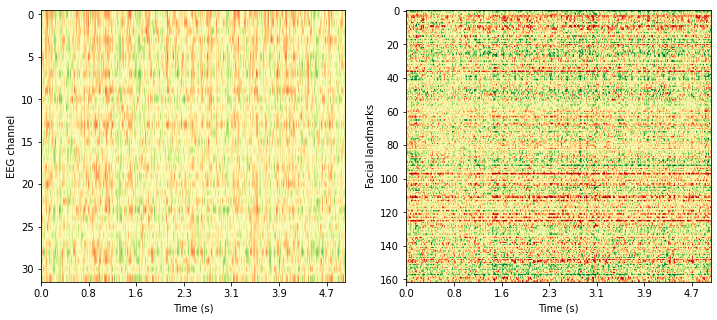

In [84]:
# Creating an analyzer for pre_trained model 
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model_wo_sm_pretrain)
# Applying the analyzer
analysis_pre_16 = gradient_analyzer.analyze([valid_X_eeg[:], valid_X_fl[:]])
analysis_eeg_16 = normalize(analysis_pre_16[0]).mean(axis =0)
analysis_fl_16 = normalize(analysis_pre_16[1]).mean(axis =0)

unit = [0, 100, 200, 300, 400, 500, 600]
t = [round(i/128, 1) for i in unit] 
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(analysis_eeg_8.squeeze().transpose(1,0), cmap='RdYlGn_r', aspect='auto', clim=[-0.06,0.06])
plt.xticks(ticks=unit, labels= t)
plt.ylabel('EEG channel')
plt.xlabel('Time (s)')
plt.subplot(1,2,2)
plt.imshow(analysis_fl_8.squeeze().transpose(1,0), cmap='RdYlGn_r', aspect='auto', clim=[-0.06,0.06])
plt.xlabel('Time (s)')
plt.ylabel('Facial landmarks')
plt.xticks(ticks=unit, labels= t)
#plt.colorbar()

plt.show()


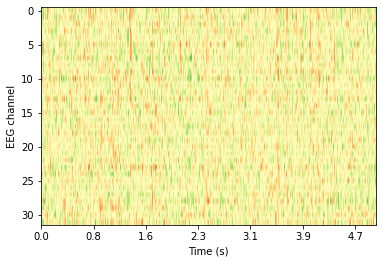

In [81]:
# Creating an analyzer for baseline model EEG
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model_wo_sm_eeg)
# Applying the analyzer
analysis_bl_eeg_16 = gradient_analyzer.analyze(valid_X_eeg[:])
analysis_eeg_only_16 = normalize(analysis_bl_eeg_16).mean(axis =0)

plt.imshow(analysis_eeg_only_8.squeeze().transpose(1,0), cmap='RdYlGn_r', aspect='auto', clim=[-0.06,0.06])
unit = [0, 100, 200, 300, 400, 500, 600]
t = [round(i/128, 1) for i in unit] 
plt.xlabel('Time (s)')
plt.ylabel('EEG channel')
plt.xticks(ticks=unit, labels= t)
#plt.colorbar()
plt.show()

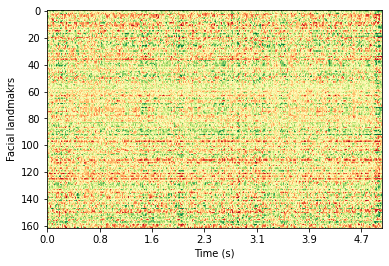

In [80]:
 # Creating an analyzer for baseline model FL
 def normalize(v):
    norm=np.linalg.norm(v, axis = 0)
    return v/norm
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model_wo_sm_fl)
# Applying the analyzer
analysis_bl_fl_16 = gradient_analyzer.analyze(valid_X_fl[:])
analysis_fl_only_16 = normalize(analysis_bl_fl_16).mean(axis =0)

plt.imshow(analysis_fl_only_8.squeeze().transpose(1,0), cmap='RdYlGn_r', aspect='auto', clim=[-0.06,0.06])
unit = [0, 100, 200, 300, 400, 500, 600]
t = [round(i/128, 1) for i in unit] 
plt.xlabel('Time (s)')
plt.ylabel('Facial landmakrs')
plt.xticks(ticks=unit, labels= t)
#plt.colorbar()
plt.show()

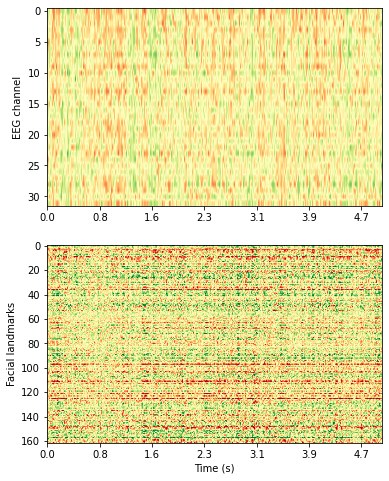

In [85]:
# Creating an analyzer for pre_trained model 
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model_wo_sm_double)
# Applying the analyzer
analysis_double_16 = gradient_analyzer.analyze([valid_X_eeg[:], valid_X_fl[:]])
analysis_eeg_16_double = normalize(analysis_double_16[0]).mean(axis =0)
analysis_fl_16_double = normalize(analysis_double_16[1]).mean(axis =0)

unit = [0, 100, 200, 300, 400, 500, 600]
t = [round(i/128, 1) for i in unit] 
plt.figure(figsize=(6,8))
plt.subplot(2,1,1)
plt.imshow(analysis_eeg_8.squeeze().transpose(1,0), cmap='RdYlGn_r', aspect='auto',  clim=[-0.06,0.06])
plt.xticks(ticks=unit, labels= t)
plt.ylabel('EEG channel')
plt.subplot(2,1,2)
plt.imshow(analysis_fl_8.squeeze().transpose(1,0), cmap='RdYlGn_r', aspect='auto', clim=[-0.06,0.06])
plt.xlabel('Time (s)')
plt.ylabel('Facial landmarks')
plt.xticks(ticks=unit, labels= t)

plt.show()


Analyzing temporal relevance

In [48]:
# Applying the analyzer
from scipy import stats
import math
corr_8=[]
eeg_t = abs(normalize(analysis_double_16[0])).squeeze().mean(axis=0).transpose(1,0)
fl_t= abs(normalize(analysis_double_16[1])).squeeze().mean(axis =0).transpose(1,0)
for i in eeg_t:
  for j in fl_t:
    c=stats.pearsonr(i, j)[0]
    corr_8.append(abs(c))
print(max(corr_8))

0.16239516787720856


In [66]:
from scipy import stats
eeg_t = abs(normalize(analysis_pre_16[0])).squeeze().mean(axis=(0,2))
fl_t= abs(normalize(analysis_pre_16[1])).squeeze().mean(axis =(0,2))
stats.pearsonr(eeg_t, fl_t)

(0.050469779142004026, 0.20226947639964452)

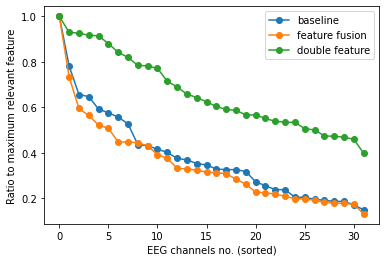

In [67]:
def sorted_relevance(data):
  channels_sorted = abs(data).mean(axis = 1).argsort()
  channels_norm = abs(data).mean(axis =1)

  return np.flip(channels_norm.squeeze()[channels_sorted[:,:]].squeeze())

def top_relevance(data):
  channels_sorted = abs(data).mean(axis = 1).argsort()
  return channels_sorted[:, -5:]

def ratio_to_max(data):
  max = np.max(data)
  return data/max

eeg_bl = sorted_relevance(analysis_eeg_only_16)
eeg_pre = sorted_relevance(analysis_eeg_16)
eeg_double = sorted_relevance(analysis_eeg_16_double)

plt.plot(ratio_to_max(eeg_bl), '-o', label ='baseline')
plt.plot(ratio_to_max(eeg_pre), '-o', label = 'feature fusion')
plt.plot(ratio_to_max(eeg_double), '-o', label = 'double feature')

plt.xlabel('EEG channels no. (sorted)')
plt.ylabel('Ratio to maximum relevant feature')
plt.legend()
#plt.plot(np.flip(abs(analysis_8).mean(axis=1).squeeze()[channels_8[:,-5:]].squeeze()), '-o')

In [65]:
print(top_relevance(analysis_fl_8)//2)
print(top_relevance(analysis_fl_only_8)//2)
print(top_relevance(analysis_fl_10)//2)
print(top_relevance(analysis_fl_only_10)//2)
print(top_relevance(analysis_fl_15)//2)
print(top_relevance(analysis_fl_only_15)//2)
print(top_relevance(analysis_fl_16)//2)
print(top_relevance(analysis_fl_only_16)//2)

[[55  7 62  9  8]]
[[ 7 48 62 18 55]]
[[ 7 69 36  8 60]]
[[ 4  8 59 69 75]]
[[ 7 60 49 15  8]]
[[32  8  7 49 15]]
[[69  8 72 71 70]]
[[80  5 74 64  7]]
